In [1]:
!nvidia-smi

zsh:1: command not found: nvidia-smi


In [2]:
# install tensorflow 2.15 since voxelmorph is not compatible with current build
import tensorflow as tf

if not tf.__version__.startswith('2.15'):
    !pip uninstall -y tensorflow
    !pip install tensorflow==2.15
# install voxelmorph
!pip install voxelmorph

2024-08-16 12:21:30.750515: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
import voxelmorph as vxm
import neurite as ne

import os
import urllib.request
import zipfile
import json
import nibabel as nib
import matplotlib.pyplot as plt
from matplotlib import colors, patches
import numpy as np
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [4]:
# download dataset
filename = 'AbdomenCTCT.zip'
if not os.path.exists(filename):
    url = 'https://cloud.imi.uni-luebeck.de/s/32WaSRaTnFk2JeT/download/AbdomenCTCT.zip'
    urllib.request.urlretrieve(url, filename)

    # extract files
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('./')

In [5]:
def load_data(jsonData, dataFolderPath, training_or_test, filterString='0001'):
    images = []
    labels = []
    for sample in jsonData[training_or_test]:
        image = nib.load(dataFolderPath + sample['image'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
        images.append(image)
        if training_or_test == 'training':
            label = nib.load(dataFolderPath + sample['label'].removeprefix('.').replace(".csv", ".nii.gz")).get_fdata()
            labels.append(label)

    return np.array(images), np.array(labels)

In [6]:
# load data
with open('./AbdomenCTCT/AbdomenCTCT_dataset.json', 'r') as file:
    data_json = json.load(file)
dataFolder = './AbdomenCTCT'
images_raw, labels_raw = load_data(data_json, dataFolder, 'training')

In [7]:
images_raw.shape

(30, 192, 160, 256)

In [8]:
labels_raw.shape

(30, 192, 160, 256)

# Preprocess data

In [9]:
# normalize images
images_normalized = (images_raw - np.min(images_raw)) / (np.max(images_raw) - np.min(images_raw))

# rotate tensor
images_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in images_normalized])
labels_rotated = np.array([np.rot90(image, k=1, axes=(0, 2)) for image in labels_raw])

# swap and flip axes
images = np.swapaxes(images_rotated, 1, 2)[:, ::-1, :, :]
labels = np.swapaxes(labels_rotated, 1, 2)[:, ::-1, :, :]

In [10]:
del images_raw
del labels_raw
del images_normalized
del images_rotated
del labels_rotated

(-0.5, 191.5, 255.5, -0.5)

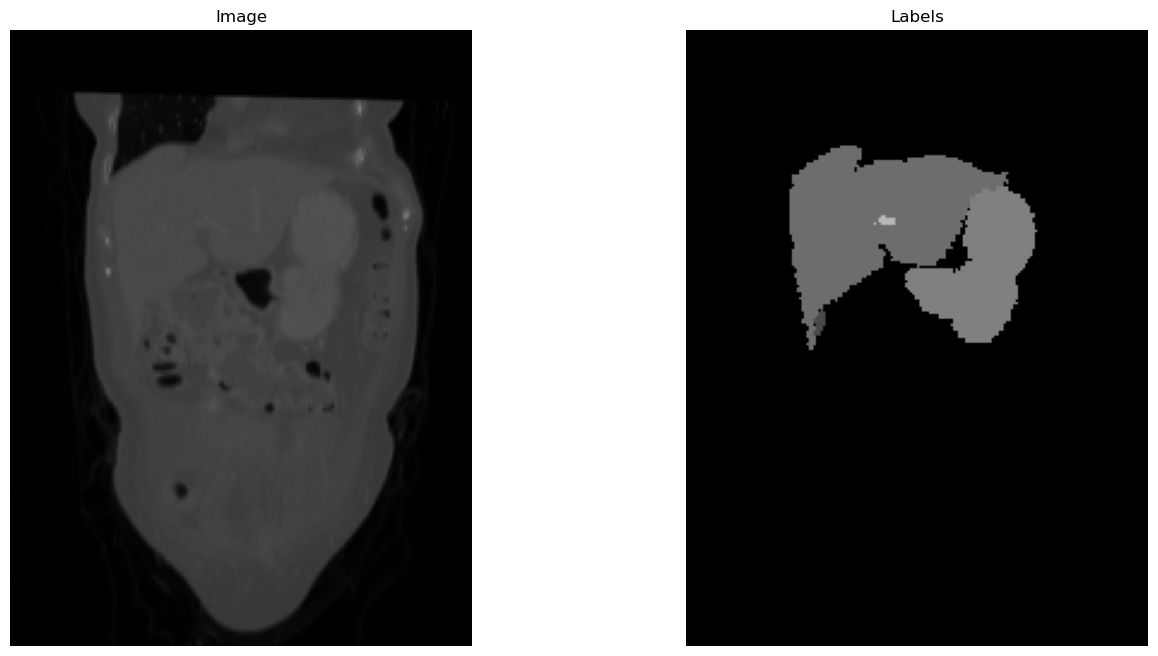

In [11]:
# preview data
img = 0
depth = 40

fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(16, 8))
ax0.imshow(images[img, depth], cmap='gray', vmin=0, vmax=1)
ax0.set_title("Image")
ax0.axis("off")
ax1.imshow(labels[img, depth], cmap='gray', vmin=0, vmax=14)
ax1.set_title("Labels")
ax1.axis("off")

In [12]:
# split dataset
_, test_images = train_test_split(images, test_size=0.2, random_state=10)
_, test_labels = train_test_split(labels, test_size=0.2, random_state=10)

In [22]:
del images
del labels
del _

In [14]:
test_images.shape

(6, 160, 256, 192)

# Define Model

In [15]:
legend_labels = {
    1: "spleen",
    2: "right kidney",
    3: "left kidney",
    4: "gall bladder",
    5: "esophagus",
    6: "liver",
    7: "stomach",
    8: "aorta",
    9: "inferior vena cava",
    10: "portal and splenic vein",
    11: "pancreas",
    12: "left adrenal gland",
    13: "right adrenal gland"
}

# define the input shapes
inshape = test_images.shape[1:]
nb_features = (
    (16, 32, 32),  # encoder-channels
    (32, 32, 16, 16)  # decoder-channels
)

# build model using VxmDense
spleen_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
spleen_model.load_weights('models/AbdomenCTCT_' + legend_labels[1] + '_model.h5')
rkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
rkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[2] + '_model.h5')
lkidney_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
lkidney_model.load_weights('models/AbdomenCTCT_' + legend_labels[3] + '_model.h5')
gbladder_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
gbladder_model.load_weights('models/AbdomenCTCT_' + legend_labels[4] + '_model.h5')
esophagus_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
esophagus_model.load_weights('models/AbdomenCTCT_' + legend_labels[5] + '_model.h5')
liver_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
liver_model.load_weights('models/AbdomenCTCT_' + legend_labels[6] + '_model.h5')
stomach_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
stomach_model.load_weights('models/AbdomenCTCT_' + legend_labels[7] + '_model.h5')
aorta_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
aorta_model.load_weights('models/AbdomenCTCT_' + legend_labels[8] + '_model.h5')
ivc_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ivc_model.load_weights('models/AbdomenCTCT_' + legend_labels[9] + '_model.h5')
pandsvein_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pandsvein_model.load_weights('models/AbdomenCTCT_' + legend_labels[10] + '_model.h5')
pancreas_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
pancreas_model.load_weights('models/AbdomenCTCT_' + legend_labels[11] + '_model.h5')
ladrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
ladrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[12] + '_model.h5')
radrenalgland_model = vxm.networks.VxmDense(inshape, nb_features, int_steps=0)
radrenalgland_model.load_weights('models/AbdomenCTCT_' + legend_labels[13] + '_model.h5')

# Test registration

In [26]:
# define a data generator
def test_data_generator(images, labels):
    while True:
        idx1 = np.random.randint(0, images.shape[0], size=1)
        idx2 = np.random.randint(0, images.shape[0], size=1)
        while idx2 == idx1:
            idx2 = np.random.randint(0, images.shape[0], size=1)

        fixed_image = images[idx1, ..., np.newaxis]
        fixed_labels = labels[idx1, ..., np.newaxis]

        moving_image = images[idx2, ..., np.newaxis]
        moving_labels = labels[idx2, ..., np.newaxis]

        yield fixed_image, fixed_labels, moving_image, moving_labels

In [27]:
# define validation generator
test_generator = test_data_generator(test_images, test_labels)

In [32]:
# get test sample
test_input = next(test_generator)

In [35]:
test_input[1].shape

(1, 160, 256, 192, 1)

In [39]:
each_org_transformation = []

for organ in tqdm(legend_labels):
    fixed_input = np.zeros_like(test_input[0])
    fixed_input[test_input[1] == organ] = test_input[0][test_input[1] == organ]
    moving_input = np.zeros_like(test_input[2])
    moving_input[test_input[3] == organ] = test_input[2][test_input[3] == organ]
    
    if organ == 1:
        test_pred = tuple(spleen_model.predict((fixed_input, moving_input)))
    elif organ == 2:
        test_pred = tuple(rkidney_model.predict((fixed_input, moving_input)))
    elif organ == 3:
        test_pred = tuple(lkidney_model.predict((fixed_input, moving_input)))
    elif organ == 4:
        test_pred = tuple(gbladder_model.predict((fixed_input, moving_input)))
    elif organ == 5:
        test_pred = tuple(esophagus_model.predict((fixed_input, moving_input)))
    elif organ == 6:
        test_pred = tuple(liver_model.predict((fixed_input, moving_input)))
    elif organ == 7:
        test_pred = tuple(stomach_model.predict((fixed_input, moving_input)))
    elif organ == 8:
        test_pred = tuple(aorta_model.predict((fixed_input, moving_input)))
    elif organ == 9:
        test_pred = tuple(ivc_model.predict((fixed_input, moving_input)))
    elif organ == 10:
        test_pred = tuple(pandsvein_model.predict((fixed_input, moving_input)))
    elif organ == 11:
        test_pred = tuple(pancreas_model.predict((fixed_input, moving_input)))
    elif organ == 12:
        test_pred = tuple(ladrenalgland_model.predict((fixed_input, moving_input)))
    else:
        test_pred = tuple(radrenalgland_model.predict((fixed_input, moving_input)))

    each_org_transformation.append(test_pred[0][0])

  0%|          | 0/13 [00:00<?, ?it/s]

1/1 [==============================] - 12s 12s/step


  8%|▊         | 1/13 [00:13<02:36, 13.07s/it]

1/1 [==============================] - 9s 9s/step


 15%|█▌        | 2/13 [00:22<02:03, 11.19s/it]

1/1 [==============================] - 10s 10s/step


 23%|██▎       | 3/13 [00:33<01:50, 11.02s/it]

1/1 [==============================] - 9s 9s/step


 31%|███       | 4/13 [00:43<01:34, 10.55s/it]

1/1 [==============================] - 9s 9s/step


 38%|███▊      | 5/13 [00:53<01:21, 10.25s/it]

1/1 [==============================] - 10s 10s/step


 46%|████▌     | 6/13 [01:03<01:11, 10.25s/it]

1/1 [==============================] - 9s 9s/step


 54%|█████▍    | 7/13 [01:12<00:59,  9.88s/it]

1/1 [==============================] - 8s 8s/step


 62%|██████▏   | 8/13 [01:21<00:47,  9.52s/it]

1/1 [==============================] - 8s 8s/step


 69%|██████▉   | 9/13 [01:29<00:36,  9.05s/it]

1/1 [==============================] - 12s 12s/step


 77%|███████▋  | 10/13 [01:41<00:30, 10.01s/it]

1/1 [==============================] - 9s 9s/step


 85%|████████▍ | 11/13 [01:51<00:19,  9.94s/it]

1/1 [==============================] - 8s 8s/step


 92%|█████████▏| 12/13 [01:59<00:09,  9.46s/it]

1/1 [==============================] - 9s 9s/step


100%|██████████| 13/13 [02:08<00:00,  9.89s/it]


(-0.5, 191.5, 255.5, -0.5)

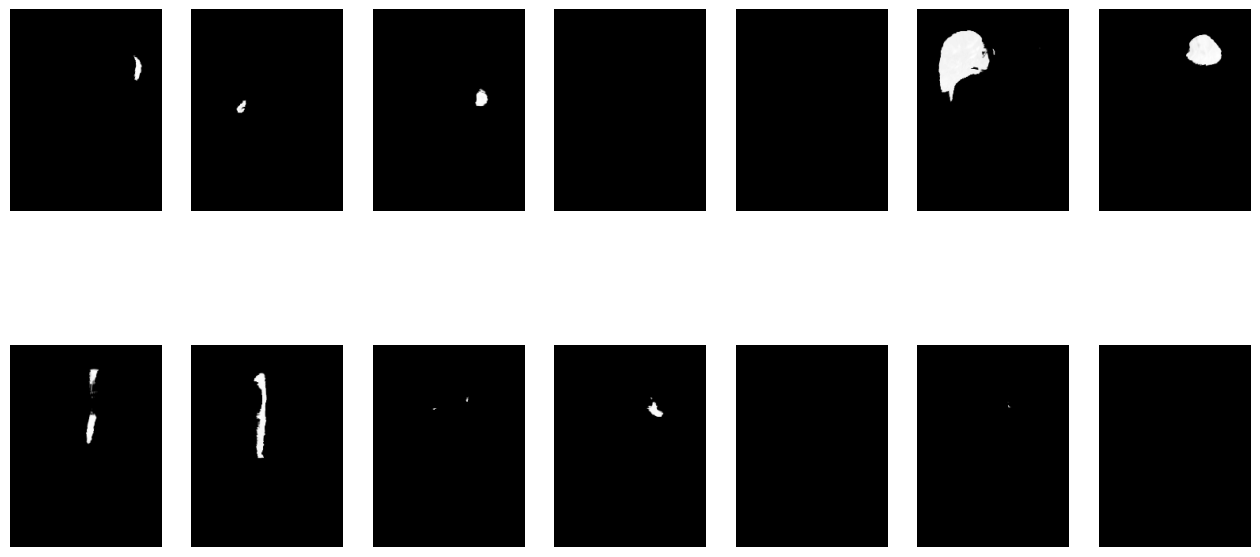

In [41]:
depth = 80

fig, ax = plt.subplots(ncols=7, nrows=2, figsize=(16, 8))
ax[0, 0].imshow(each_org_transformation[0][depth], cmap='gray')
ax[0, 0].axis('off')
ax[0, 1].imshow(each_org_transformation[1][depth], cmap='gray')
ax[0, 1].axis('off')
ax[0, 2].imshow(each_org_transformation[2][depth], cmap='gray')
ax[0, 2].axis('off')
ax[0, 3].imshow(each_org_transformation[3][depth], cmap='gray')
ax[0, 3].axis('off')
ax[0, 4].imshow(each_org_transformation[4][depth], cmap='gray')
ax[0, 4].axis('off')
ax[0, 5].imshow(each_org_transformation[5][depth], cmap='gray')
ax[0, 5].axis('off')
ax[0, 6].imshow(each_org_transformation[6][depth], cmap='gray')
ax[0, 6].axis('off')
ax[1, 0].imshow(each_org_transformation[7][depth], cmap='gray')
ax[1, 0].axis('off')
ax[1, 1].imshow(each_org_transformation[8][depth], cmap='gray')
ax[1, 1].axis('off')
ax[1, 2].imshow(each_org_transformation[9][depth], cmap='gray')
ax[1, 2].axis('off')
ax[1, 3].imshow(each_org_transformation[10][depth], cmap='gray')
ax[1, 3].axis('off')
ax[1, 4].imshow(each_org_transformation[11][depth], cmap='gray')
ax[1, 4].axis('off')
ax[1, 5].imshow(each_org_transformation[12][depth], cmap='gray')
ax[1, 5].axis('off')
ax[1, 6].imshow(np.zeros_like(each_org_transformation[12][depth]), cmap='gray')
ax[1, 6].axis('off')



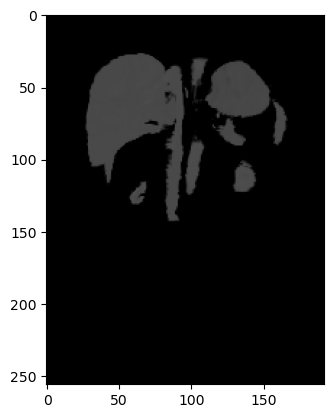

In [42]:
combination = np.maximum.reduce(each_org_transformation)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

In [63]:
def predict_organs(input):
    each_org_transformation = []

    for organ in tqdm(legend_labels):
        fixed_input = np.zeros_like(input[0])
        fixed_input[input[1] == organ] = input[0][input[1] == organ]
        moving_input = np.zeros_like(input[2])
        moving_input[input[3] == organ] = input[2][input[3] == organ]
    
        if organ == 1:
            test_pred = tuple(spleen_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 2:
            test_pred = tuple(rkidney_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 3:
            test_pred = tuple(lkidney_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 4:
            test_pred = tuple(gbladder_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 5:
            test_pred = tuple(esophagus_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 6:
            test_pred = tuple(liver_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 7:
            test_pred = tuple(stomach_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 8:
            test_pred = tuple(aorta_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 9:
            test_pred = tuple(ivc_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 10:
            test_pred = tuple(pandsvein_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 11:
            test_pred = tuple(pancreas_model.predict((fixed_input, moving_input),verbose=0))
        elif organ == 12:
            test_pred = tuple(ladrenalgland_model.predict((fixed_input, moving_input),verbose=0))
        else:
            test_pred = tuple(radrenalgland_model.predict((fixed_input, moving_input),verbose=0))

        each_org_transformation.append(test_pred[0][0])

    combination = np.maximum.reduce(each_org_transformation)

    return np.squeeze(combination, -1)

1/1 [==============================] - 8s 8s/step


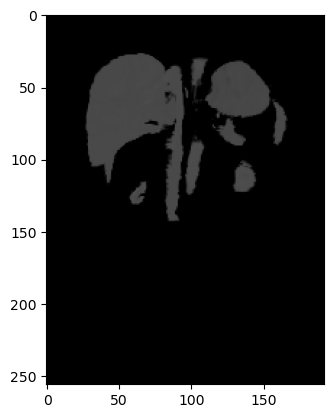

In [47]:
combination = predict_organs(test_input)

plt.imshow(combination[depth], cmap='gray', vmin=0, vmax=1)

In [51]:
combination.shape

(160, 256, 192, 1)

# Evaluation

In [48]:
def dice_score_tf(y_true, y_pred, smooth=1e-6):
    binary_y_true = tf.cast(y_true > 0, tf.float32)
    binary_y_pred = tf.cast(y_pred > 0, tf.float32)

    y_true_flat = tf.reshape(binary_y_true, [-1])
    y_pred_flat = tf.reshape(binary_y_pred, [-1])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat)
    union = tf.reduce_sum(y_true_flat) + tf.reduce_sum(y_pred_flat)

    dice = (2. * intersection + smooth) / (union + smooth)
    return float(dice)

In [49]:
test_organs = np.zeros_like(test_images)
test_organs[test_labels > 0] = test_images[test_labels > 0]

In [65]:
n = test_organs.shape[0]
count = 0
dice = 0
mse = 0

for i in range(n):
    for j in range(n):
        if i == j:
            continue
        else:
            count += 1
            print(f"Step {count}/{n*n-n}:")
            combined_prediction = predict_organs((test_images[[i], ..., np.newaxis], test_labels[[i], ..., np.newaxis], test_images[[j], ..., np.newaxis], test_labels[[j], ..., np.newaxis]))
            dice += dice_score_tf(test_organs[j], combined_prediction)
            mse += np.mean(np.square(test_organs[j] - combined_prediction))
            
            print("- Current DICE: " + str(dice / count))
            print("- Current MSE: " + str(mse / count))

Step 1/30:


  0%|          | 0/13 [00:13<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print("Final DICE: " + str(dice / count))
print("Final MSE: " + str(mse / count))